### Home work № 4:

In [1]:
%matplotlib inline

import graphviz
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k, uplift_by_percentile, uplift_auc_score, qini_auc_score
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve, plot_qini_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [2]:
# Чтение данных
df = pd.read_csv('hw_data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


##### Переименуем поля (conversion -> target, offer -> treatment) и приведем поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.



In [4]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


#### Feature Engineering

In [5]:
df.loc[(df['treatment'] == 'Buy One Get One') & (df['used_bogo'] == 1), 'was_offer_used'] = 'used'
df.loc[(df['treatment'] == 'Discount') & (df['used_discount'] == 1), 'was_offer_used'] = 'used'
df.loc[(df['used_bogo'] == 0) & (df['used_discount'] == 0), 'was_offer_used'] = 'never_saw_an_offer'
df.loc[df['was_offer_used'].isna(), 'was_offer_used'] = 'not_used'
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,was_offer_used
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,not_used
1,6,329.08,1,1,Rural,1,Web,No Offer,0,not_used
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,used
3,9,675.83,1,0,Rural,1,Web,Discount,0,used
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,not_used


In [6]:
median_history_purchases_on_zip_code = df.groupby(['zip_code'], as_index=False).agg({'history':'median'})\
                       .rename(columns={'history':'median_history_purchases_on_zip_code'})
df = df.merge(median_history_purchases_on_zip_code, on='zip_code', how='left')

median_history_purchases_on_zip_code

,zip_code,median_history_purchases_on_zip_code
0,Rural,159.58
1,Surburban,155.52
2,Urban,160.28


In [7]:
median_history_purchases_on_offer_used = df.groupby(['was_offer_used'], as_index=False).agg({'history':'median'})\
                       .rename(columns={'history':'median_history_purchases_on_offer_used'})
df = df.merge(median_history_purchases_on_offer_used, on='was_offer_used', how='left')

median_history_purchases_on_offer_used

,was_offer_used,median_history_purchases_on_offer_used
0,not_used,146.115
1,used,183.845


In [8]:
df['history_on_recency_duration'] = df['history'] / df['recency']

In [9]:
# В конце заменим 'treatment' на 1 и 0 соответственно, в зависимости от того, было воздействие или нет.
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

df.groupby(["treatment", "target"], as_index=False).agg({'channel':'count'})\
                       .rename(columns={'channel':'count'})

,treatment,target,count
0,0,0,19044
1,0,1,2262
2,1,0,35562
3,1,1,7132


In [10]:
df['treatment'] = df['treatment'].astype(str).astype(int)

In [11]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,was_offer_used,median_history_purchases_on_zip_code,median_history_purchases_on_offer_used,history_on_recency_duration
0,10,142.44,1,0,Surburban,0,Phone,1,0,not_used,155.52,146.115,14.244000
1,6,329.08,1,1,Rural,1,Web,0,0,not_used,159.58,146.115,54.846667
2,7,180.65,0,1,Surburban,1,Web,1,0,used,155.52,183.845,25.807143
3,9,675.83,1,0,Rural,1,Web,1,0,used,159.58,183.845,75.092222
4,2,45.34,1,0,Urban,0,Web,1,0,not_used,160.28,146.115,22.670000


#### Сделаем разбиение набора данных не тренировочную и тестовую выборки.

In [12]:
y = df["target"]
X = df.drop(columns=["target"])
X_train_draft, X_test_draft, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                                stratify=y, test_size=0.25, random_state=42)

In [13]:
X_train = X_train_draft.drop(columns=["treatment"])
treat_train = X_train_draft['treatment']

X_test = X_test_draft.drop(columns=["treatment"])
treat_test = X_test_draft['treatment']

cat_features = ['zip_code', 'channel', 'was_offer_used']

models_results = {
    'approach': [],
    'uplift@10%': [], 
    'uplift@20%': [] # Это значит топ-20% юзеров с самым большим значением метрики uplift
}

### Подход с одной моделью (с признаком коммуникации)

uplift@10%: 0.0577, uplift@20%: 0.0480


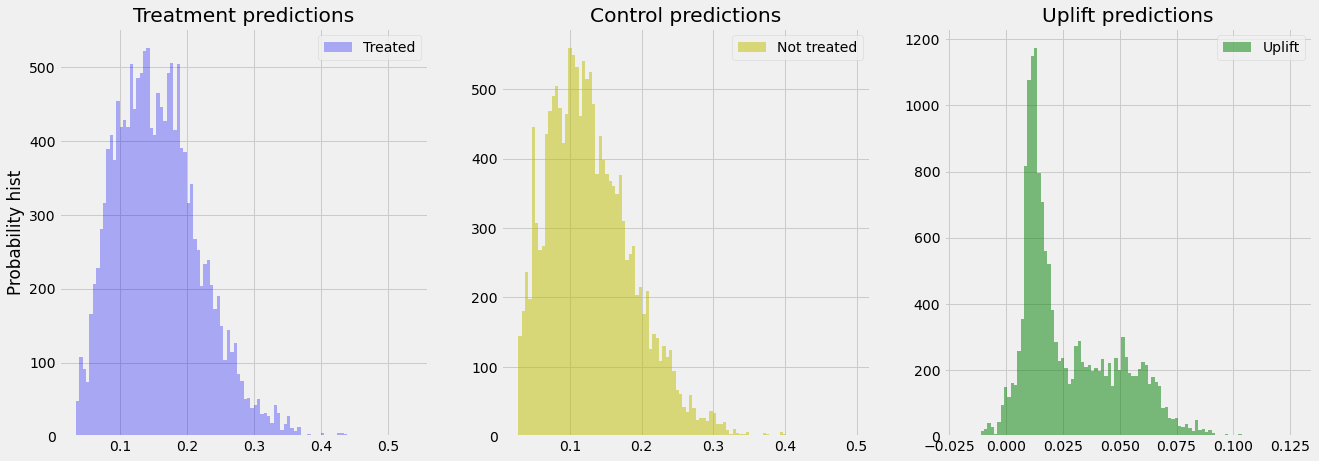

In [14]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}, uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [15]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,16.448675
1,median_history_purchases_on_zip_code,13.915286
2,treatment,9.844660
3,median_history_purchases_on_offer_used,9.656268
4,used_discount,8.027786
5,channel,7.986898
6,used_bogo,7.153546
7,history,6.751136
8,history_on_recency_duration,6.729002
9,was_offer_used,6.304874


##### Uplift by percentile

In [16]:
uplift_by_percentile(y_test, uplift_sm, treat_test, strategy='overall', total=True, std=True, bins=10)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,801,799,0.197253,0.132666,0.064588,0.014060,0.012001,0.018485
10-20,842,758,0.180523,0.094987,0.085536,0.013255,0.010649,0.017003
20-30,1029,571,0.173955,0.071804,0.102151,0.011817,0.010804,0.016011
30-40,1232,368,0.215097,0.084239,0.130858,0.011706,0.014479,0.018619
40-50,1275,325,0.200000,0.187692,0.012308,0.011202,0.021659,0.024385
50-60,1207,393,0.181442,0.185751,-0.004309,0.011093,0.019618,0.022537
60-70,1010,590,0.135644,0.100000,0.035644,0.010774,0.012351,0.016390
70-80,1013,587,0.128332,0.090290,0.038042,0.010508,0.011829,0.015823
80-90,1086,514,0.107735,0.071984,0.035750,0.009408,0.011400,0.014781


##### График uplift by percentile

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


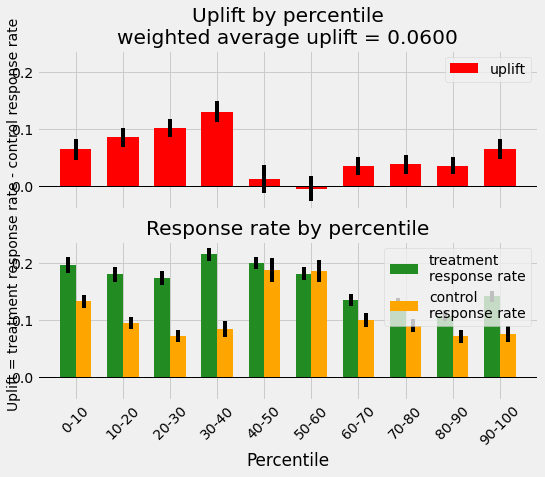

In [17]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, strategy='overall', kind='bar');

##### В левой части графика как раз находятся убеждаемые - тот тип, которых мы хотим найти.

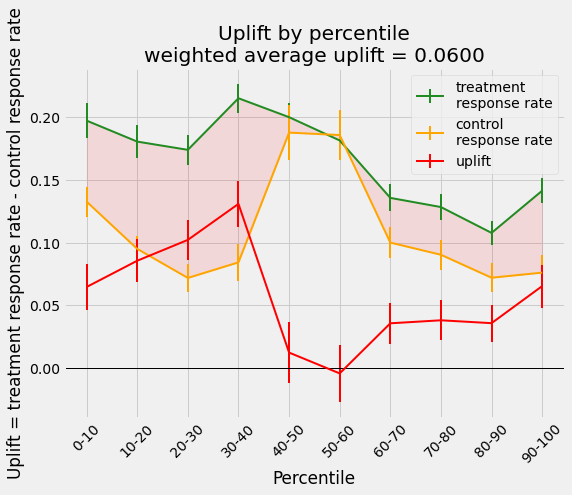

In [18]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, strategy='overall', kind='line');

#### Uplift curve

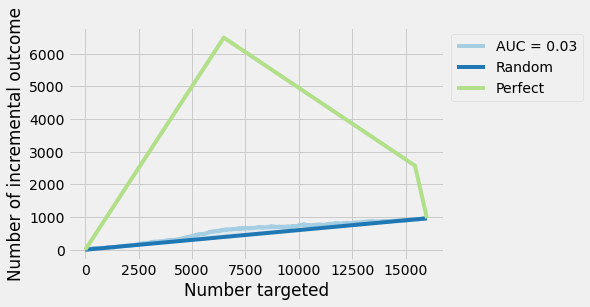

In [19]:
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=True);

In [20]:
# AUUQ = area under uplift curve
auuc = uplift_auc_score(y_test, uplift_sm, treat_test) 
print(f"Uplift auc score on full data: {auuc:.4f}")

Uplift auc score on full data: 0.0257


#### Qini curve

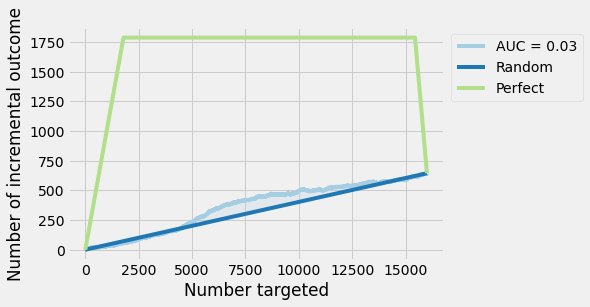

In [21]:
plot_qini_curve(y_test, uplift_sm, treat_test, perfect=True);

In [22]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_sm, treat_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0300


### Подход с одной моделью (трансформация классов)

In [23]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

### Две независимые модели

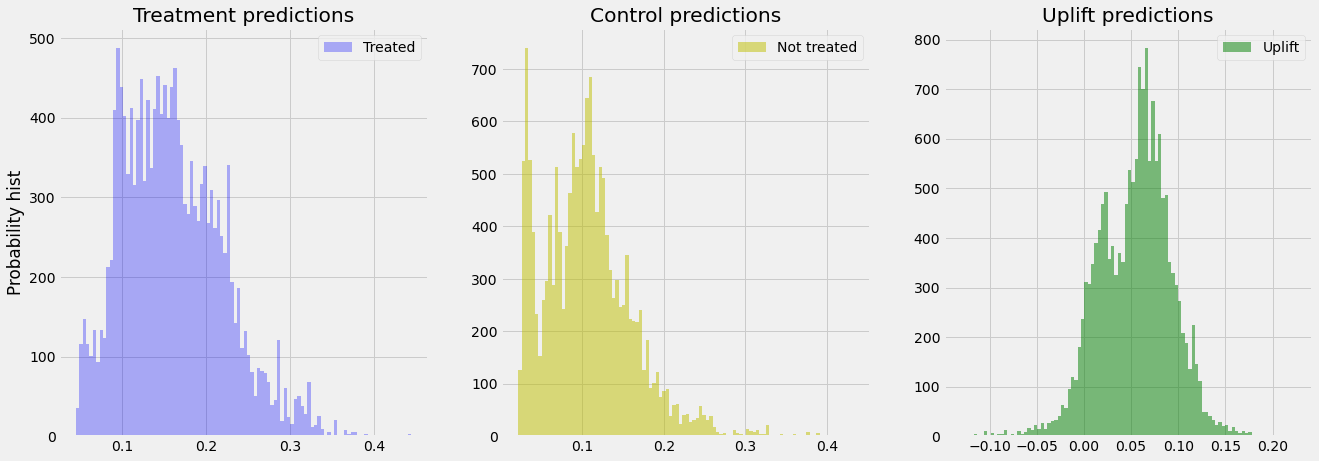

In [24]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### Сравнение подходов:

In [26]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.132673,0.121131
0,SoloModel,0.057679,0.047999
1,ClassTransformation,-0.021468,0.020978


#### В этом кейсе подход TwoModels оказался гораздо лучше других.